In [1]:
import numpy as np
from typing import Optional, List, Tuple
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import torch


from tqdm.notebook import trange, tqdm
from omegaconf import OmegaConf, DictConfig

# Set precision to 3 decimal places
np.set_printoptions(precision=3, suppress=True)

import pickle

from discrete_maze.maze import Maze, AStar
from discrete_maze.search_algorithm import GreedyAlgorithm, SearchAlgorithm,  LearnedAStar, AlphaMCTS
from discrete_maze.maze_dataset import MazeDataset
from discrete_maze.resnet import ResNet

In [2]:
# Define the configuration using OmegaConf
cfg = OmegaConf.create({
    "maze": {
        "width": {"min": 4, "max": 50},
        "height": {"min": 4, "max": 50},
        "cell_occupancy_prob": {"min": 0, "max": 0.3},
        "max_steps": "ShortestPath", # Use this to set the max steps to the shortest path between source and target * 2
        # "max_steps": "L1SourceTarget", # Use this to set the max steps to the L1 distance between source and target * 2
        # To set paramters to constant values, use a float
        # "width": 4,
        # "height": 4,
        # "cell_occupancy_prob": 0,
        # "max_steps": 5, 
    },
    "model": {
        "num_resBlocks": 4,
        "num_filters": 64,
        "history_length": 8, # Number of current and previous states to consider, 1 for current state only
    },
    "search": {
        # MCTS configuration
        "num_simulations": 50,
        "c_puct": 2,
    },
})

In [3]:
import pandas as pd

def summarize_results(results, name):
    df = pd.DataFrame(results, columns=['termination_case', 'value'])
    percentages = df['termination_case'].value_counts(normalize=True) * 100

    # Compute average optimal path ratio for successful runs
    average_optimal_path_ratio = df['value'].mean()

    print(f"Results for {name}:")
    print(f"% Target Reached: {percentages.get(SearchAlgorithm.TerminationCase.TARGET_REACHED, 0):.2f}%")
    print(f"% Timed Out: {percentages.get(SearchAlgorithm.TerminationCase.TIMEOUT, 0):.2f}%")
    print(f"% Collided: {percentages.get(SearchAlgorithm.TerminationCase.COLLISION, 0):.2f}%")
    print(f"% Failed: {percentages.get(SearchAlgorithm.TerminationCase.FAILED, 0):.2f}%")
    print(f"Average path_length/optimal_path_length: {average_optimal_path_ratio:.4f}\n")

In [4]:
# maze = Maze(50,50,0.2,"ShortestPath")
# maze.visualize_path()

  0%|          | 0/1 [00:00<?, ?it/s]

Seed: 761440
A* evaluated 30 nodes


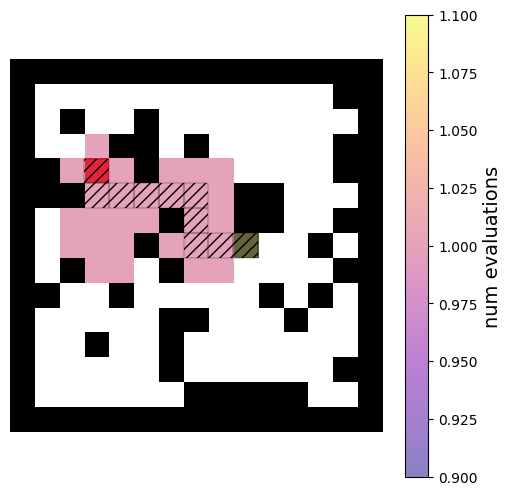

A* evaluated 82 nodes


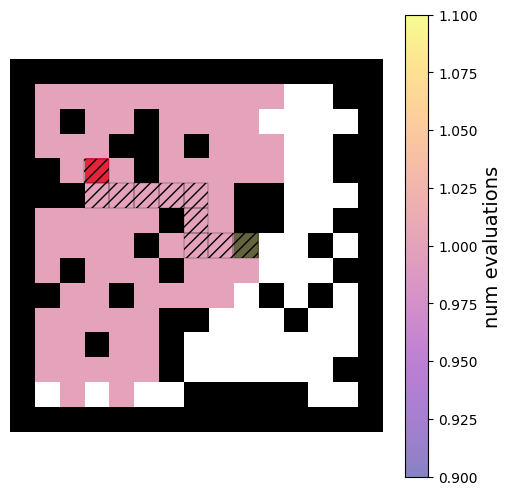

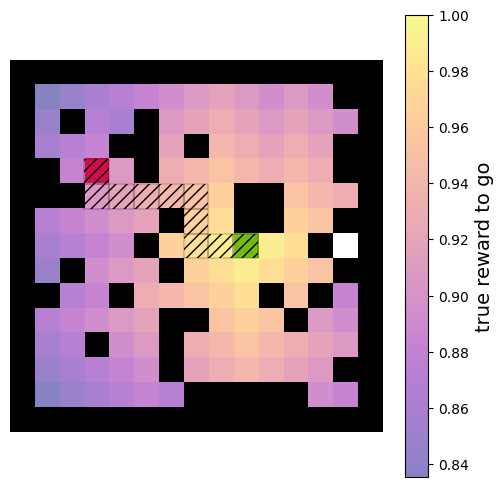

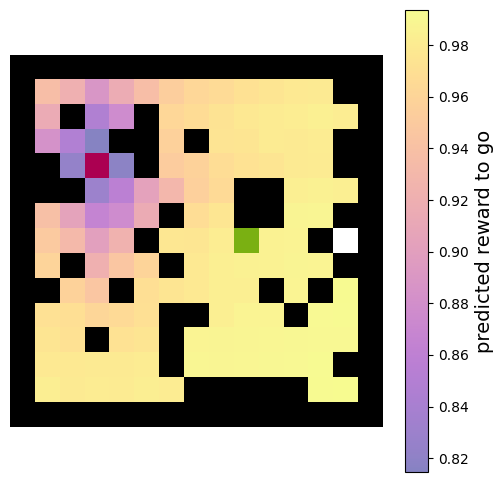

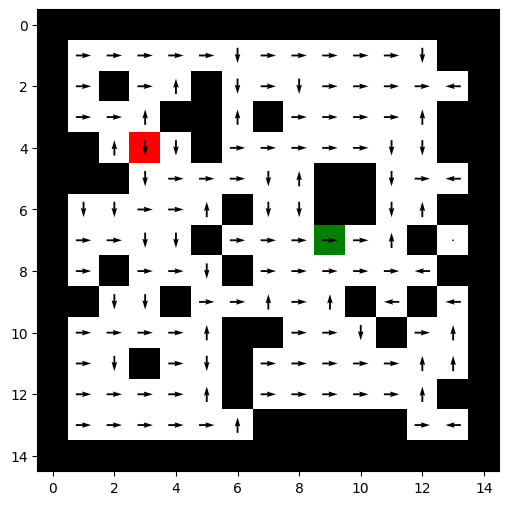

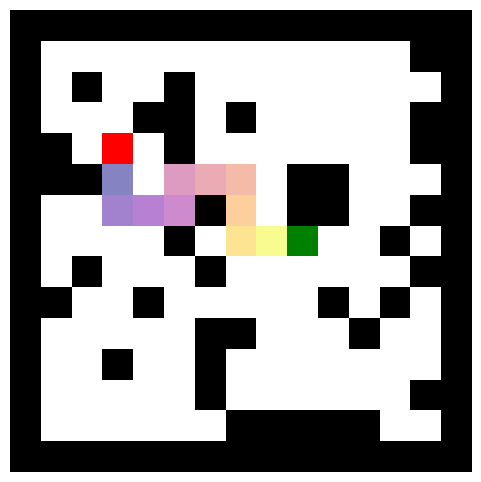

Reached target in 11 steps


In [5]:
# A Star vs Learned A Star

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

models_to_test = {
    "Behavior Cloning 500k": f"../checkpoints/maze_4to50_0to0p3_500000_bc_model_{14}.pt",
    # "Behavior Cloning 50k": f"../checkpoints/maze_4to50_0to0p3_50000_bc_model_{10}.pt",
    # "Expert Iteration n_sim 50": f"../checkpoints/maze_4to100_hist8_model_{99}.pt",
    # "Expert Iteration n_sim 300": f"../checkpoints/maze_4to100_hist8_numsim300_model_{99}.pt",
}
models = {}
for name, path in models_to_test.items():
    model = ResNet(cfg.model, device)
    model.load_state_dict(torch.load(path, weights_only=True))
    models[name] = model


n_games = 1
results = {model_name: [] for model_name in models.keys()}
algs = {model_name: LearnedAStar(search_cfg=None, model=model) for model_name, model in models.items()}
greedy_alg = GreedyAlgorithm(search_cfg=None, model=models["Behavior Cloning 500k"])

for _ in trange(n_games):
    seed = np.random.randint(500000, 1000000)
    # seed = 13144
    np.random.seed(seed)
    print(f"Seed: {seed}")
    maze_params = Maze.generate_maze_params(1, maze_cfg=cfg.maze)
    # maze = Maze(*maze_params[0])
    # maze = Maze(50,50,0,"ShortestPath", source=(15, 35), target=(5, 10))
    maze = Maze(15,15,0.2,"ShortestPath")
    astar = AStar(maze)
    astar.solve(verbose=True, use_heuristic=True)
    astar.solve(verbose=True, use_heuristic=False)
    astar.visualize_reward_to_go()
    for model_name, alg in algs.items():
        # results[model_name].extend([alg.play_game(maze, verbose=True, visualize=True, use_policy_network=True)])
        alg.visualize_reward_to_go(maze)
        alg.visualize_policy(maze)
    greedy_alg.play_game(maze)

# for model_name, model_results in results.items():
#     summarize_results(model_results, model_name)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ResNet(cfg.model, device)
model.load_state_dict(torch.load(f"../checkpoints/maze_4to50_0to0p3_500000_bc_model_{14}.pt", weights_only=True))

# alg = AlphaMCTS(search_cfg=cfg.search, model=model)
alg = LearnedAStar(search_cfg=None, model=model)


seed = np.random.randint(0, 100000)
seed = 91875
np.random.seed(seed)
print(f"Seed: {seed}")
maze_params = Maze.generate_maze_params(1, maze_cfg=cfg.maze)
# maze = Maze(*maze_params[0])
maze = Maze(25,25,0.3, max_steps="ShortestPath")
astar = AStar(maze)
astar.solve(verbose=True, use_heuristic=True)
# astar.solve(verbose=True, use_heuristic=False)
astar.visualize_reward_to_go()
alg.visualize_reward_to_go(maze)
# _ = alg.play_game(maze, verbose=True, visualize=True, animate_search=False)
# _ = alg.play_game(maze, verbose=True, visualize=True)


In [ ]:
seed = 91875
np.random.seed(seed)
print(f"Seed: {seed}")
maze_params = Maze.generate_maze_params(1, maze_cfg=cfg.maze)
# maze = Maze(*maze_params[0])
maze = Maze(25,25,0.3, max_steps="ShortestPath")
_, _, anim = alg.play_game(maze, verbose=True, visualize=True, animate_search=True)
from IPython.display import HTML
HTML(anim.to_html5_video())

In [ ]:
# Learned A Star vs AlphaMCTS

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# models_to_test = {
#     "Behavior Cloning 500k": f"../checkpoints/maze_4to50_0to0p3_500000_bc_model_{14}.pt",
#     # "Behavior Cloning 50k": f"../checkpoints/maze_4to50_0to0p3_50000_bc_model_{10}.pt",
#     "Expert Iteration n_sim 50": f"../checkpoints/maze_4to100_hist8_model_{99}.pt",
#     # "Expert Iteration n_sim 300": f"../checkpoints/maze_4to100_hist8_numsim300_model_{99}.pt",
# }
# models = {}
# for name, path in models_to_test.items():
#     model = ResNet(cfg.model, device)
#     model.load_state_dict(torch.load(path, weights_only=True))
#     models[name] = model

# algs_to_test = [LearnedAStar, AlphaMCTS]

# n_games = 1
# algs = {}

# for model_name, model in models.items():
#     for alg in algs_to_test:
#         algs[f"{alg.__name__} ({model_name})"] = alg(search_cfg=cfg.search, model=model)

# results = {alg_name: [] for alg_name in algs.keys()}

# for _ in trange(n_games):
#     seed = np.random.randint(0, 100000)
#     np.random.seed(seed)
#     print(f"Seed: {seed}")
#     maze_params = Maze.generate_maze_params(1, maze_cfg=cfg.maze)
#     # maze = Maze(*maze_params[0])
#     maze = Maze(50,50,0,"ShortestPath")
#     astar = AStar(maze)
#     astar.solve(verbose=True, use_heuristic=True)
#     # astar.solve(verbose=True, use_heuristic=False)
#     astar.visualize_reward_to_go()
#     for name, alg in algs.items():
#         print(name)
#         results[name].extend([alg.play_game(maze, verbose=True, visualize=True)])

# for name, model_results in results.items():
#     summarize_results(model_results, name)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Sample 2D NumPy array with values in {0,1,2,3}
array = np.array([
    [0, 1, 2],
    [3, 0, 1],
    [2, 3, np.nan]
])

nrows, ncols = array.shape

# Create grid coordinates at the center of each cell
X, Y = np.meshgrid(np.arange(ncols) + 0.5, np.arange(nrows) + 0.5)

# Initialize U and V components of arrows
U = np.zeros_like(array, dtype=float)
V = np.zeros_like(array, dtype=float)

# Define the direction mapping
direction_mapping = {
    0: (0, 0.5),   # Down
    1: (0, -0.5),  # Up
    2: (-0.5, 0),  # Left
    3: (0.5, 0)    # Right
}

# Map the array values to U and V components
for direction, (u, v) in direction_mapping.items():
    U[array == direction] = u
    V[array == direction] = v

# Plot the arrows using quiver
fig, ax = plt.subplots()
ax.quiver(X, Y, U, V, angles='xy', scale_units='xy', pivot='middle', scale=1)

# Set the grid lines at integer positions (cell edges)
ax.set_xticks(np.arange(ncols + 1))
ax.set_yticks(np.arange(nrows + 1))

# Adjust plot limits to align cells with integers
ax.set_xlim(0, ncols)
ax.set_ylim(nrows, 0)  # Invert y-axis to match array indexing

# Ensure the aspect ratio is equal
ax.set_aspect('equal')

# Add grid lines for better visualization
ax.grid(True)

plt.show()

